<a href="https://colab.research.google.com/github/kierandidi/ml_advanced_hd/blob/main/gp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exercise sheet 6

##1 GP Optimization of a Toy Problem

In [1]:
!pip install Optunity GPy sobol sobol-seq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.6 MB 22.3 MB/s 
     |████████████████████████████████| 959 kB 35.1 MB/s 
     |████████████████████████████████| 71 kB 5.1 MB/s 
  Created wheel for Optunity: filename=Optunity-1.1.1-py3-none-any.whl size=72032 sha256=5d29d9cf1d6aec0e27375460df9a8db3850530d69024a9ba8172be31660aefdd
  Stored in directory: /root/.cache/pip/wheels/0d/0e/31/a4763ff822a20f88a61dd3bb1c8b78a8f25c605392fe956d07
  Created wheel for GPy: filename=GPy-1.10.0-cp37-cp37m-linux_x86_64.whl size=2565121 sha256=cb22418a5f2dbcd0ff8cc40152f36d14206d58b540be1d1933ccc4ff62360a14
  Stored in directory: /root/.cache/pip/wheels/f7/18/28/dd1ce0192a81b71a3b086fd952511d088b21e8359ea496860a
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102566 sha256=0048c952c679de50ad7767b7f9949efde077a82eb68e04d1c830fd42f624f402
  Stored in directory: /root/.cache/pip/wheels/c8/95

In [34]:
import time
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
import scipy.spatial
import scipy.stats
import math
import sobol

In [16]:
def func(x, y):
  return x**2 - x + y**2 + y - (np.cos(2 * math.pi * (x - 0.5)) + np.cos(2 * math.pi * (y + 0.5))) + 2.5

In [24]:
def toy_plot():
  x = np.linspace(-6, 6, 100)
  y = np.linspace(-6, 6, 100)
  xx, yy = np.meshgrid(x, y, sparse=True)
  z = func(xx,yy)
  plt.imshow(z, extent =(-6,6,-6,6))
  plt.colorbar()
  plt.gca().set_aspect(1)
  plt.xlabel("$x$")
  plt.ylabel("$y$")
  plt.title("toy function")

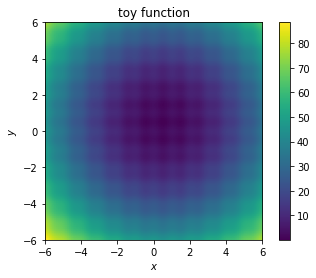

In [25]:
toy_plot()

In [31]:
#get random points in interval [-6,6]
points_rand = np.random.rand(60,2)
output = func(points_rand[:,0], points_rand[:,1])
print(scipy.stats.describe(output))

DescribeResult(nobs=60, minmax=(0.962191114776044, 5.682392487267582), mean=3.301108126243248, variance=1.2432913291673964, skewness=0.1283447180050109, kurtosis=-0.5790585159066137)


In [35]:
sample_num = 30
paramUpperLim = np.array([6,6])
paramLowerLim = np.array([-6,-6])
for i in range(sample_num):
  x,y = sobol.i4_sobol(2,i)[0] * (paramUpperLim - paramLowerLim) +paramLowerLim

##2 

In [ ]:
opt_print = lambda *args, **kwargs: None  # silence output


# opt_print = print # for debugging

def gaussian_kernel(data, sigma, max_distance):
    """Compute the gaussian kernel matrix.

    :param data: data matrix
    :param sigma: parameter sigma of the gaussian kernel
    :return: gaussian kernel matrix
    """
    assert len(data.shape) == 2
    assert sigma > 0

    factor = -0.5 / (sigma ** 2)
    limit = np.exp(factor * max_distance ** 2)
    # Find the pairwise squared distances and compute the Gaussian kernel.
    K = []
    for k in data:
        d = np.exp(factor * np.sum((data - k) ** 2, axis=1))
        d[d < limit] = 0.0  # truncate the Gaussian
        d = scipy.sparse.csc_matrix(d[:, None])
        K.append(d)
    K = scipy.sparse.hstack(K)
    return K


def compute_alpha(train_x, train_y, tau, sigma, max_distance, verbose=False):
    """Compute the alpha vector of the ridge regressor.

    :param train_x: training x data
    :param train_y: training y data
    :param tau: parameter tau of the ridge regressor
    :param sigma: parameter sigma of the gaussian kernel
    :param verbose: Print debugging information?
    :return: alpha vector
    """
    if verbose: print("Building input kernel matrix")
    K = gaussian_kernel(train_x, sigma, max_distance)
    if verbose: print("Sparsity is: %.2f%%" % (
            float(100 * K.nnz) / (K.shape[0] * K.shape[1])))
    M = K + tau * scipy.sparse.identity(train_x.shape[0])
    y = scipy.sparse.csc_matrix(train_y[:, None])
    if verbose: print("Solving sparse system")
    alpha = scipy.sparse.linalg.cg(M, train_y)
    if verbose: print("Done computing alpha")
    return alpha[0]


class KernelRidgeRegressor(object):
    """Kernel Ridge Regressor.
    """

    def __init__(self, tau, sigma):
        self.dim = None
        self.train_x = None
        self.alpha = None
        self.mean_y = None
        self.std_y = None
        self.tau = tau
        self.sigma = sigma
        self.scale = -0.5 / sigma**2
        self.max_distance = 4.0*sigma

    def train(self, train_x, train_y, verbose=False):
        """Train the kernel ridge regressor.

        :param train_x: training x data
        :param train_y: training y data
        """
        assert len(train_x.shape) == 2
        assert len(train_y.shape) == 1
        assert train_x.shape[0] == train_y.shape[0]

        self.dim = train_x.shape[1]
        self.train_x = train_x.astype(np.float32)
        self.tree = scipy.spatial.cKDTree(self.train_x)

        self.mean_y = train_y.mean()
        self.std_y = train_y.std()
        train_y_std = (train_y - self.mean_y) / self.std_y

        self.alpha = compute_alpha(self.train_x, train_y_std, self.tau,
                                   self.sigma, self.max_distance,
                                   verbose=verbose)


    def predict_single(self, pred_x):
        """Predict the value of a single instance.

        :param pred_x: x data
        :return: predicted value of pred_x
        """
        assert len(pred_x.shape) == 1
        assert pred_x.shape[0] == self.dim
        indices = np.asarray(
            self.tree.query_ball_point(pred_x, self.max_distance),
            dtype=np.dtype("i8"))
        dist = np.sum((self.train_x[indices] - pred_x) ** 2, axis=1)
        kappa = np.exp(self.scale * dist)
        pred_y = np.dot(kappa, self.alpha[indices])
        return self.std_y * pred_y + self.mean_y

    def predict(self, pred_x):
        """Predict the values of pred_x.

        :param pred_x: x data
        :return: predicted values of pred_x
        """
        assert len(pred_x.shape) == 2
        assert pred_x.shape[1] == self.dim
        pred_x = pred_x.astype(np.float32)
        return np.array([self.predict_single(x) for x in pred_x])


def kernel_ridge_regression(tau, sigma, verbose=False):
    # Load the image.
    im_orig = np.squeeze(plt.imread("cc_90.png"))

    # Make a copy, so both the original and the regressed image can be shown afterwards.
    im = np.array(im_orig)

    # Find the known pixels and the pixels that shall be predicted.
    known_ind = np.where(im != 0)
    # predict everywhere, use im == 0 to predict only unfilled values
    unknown_ind = np.where(im >= 0)
    known_x = np.array(known_ind).transpose()
    known_y = np.array(im[known_ind])
    pred_x = np.array(unknown_ind).transpose()

    # Train and predict with the given regressor.
    start = time.time()
    if verbose: print("Training...")
    r = KernelRidgeRegressor(tau, sigma)
    r.train(known_x, known_y, verbose=verbose)
    if verbose: print("Done training.")

    if verbose: print("Predicting... ", end="")
    pred_y = r.predict(pred_x)
    if verbose: print("Done.")

    # Write the predicted values back into the image and show the result.
    im[unknown_ind] = pred_y
    stop = time.time()
    if verbose: print("Train and predict took %.02f seconds." % (stop - start))
    if verbose: print(im.shape)

    return im
